In [2]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import pare, Roles, Phase
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_static_game, play_recurrent_game
from notebooks.learning_agents.static_agents import (
    random_approval_villager, 
    random_coordinated_approval_villager, 
    random_agent,
    random_approval_wolf,
    revenge_approval_wolf,
    coordinated_revenge_approval_wolf,
    random_likes_approval_wolf,
    aggressive_approval_wolf,
    )
import notebooks.learning_agents.stats as indicators
import random
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Approval Voting

Approval voting {cite}`brams1978approval` is a mechanism in which voters are not restricted to voting for just one candidate, but can vote for (approve) of as many candidates as they want. The winner (or loser in the case of werewolf) is the candidate with the most votes. As a reminder, because players are voting to eliminate another player, we have slightly modified this voting method to consider a targetting vote as a "dissaproval", no particular vote as "neutral", and a "like" as approval. Thus the player that receives the most "dissaprovals" will be eliminated. Likes and neutral opinions do not impact this vote, however allow for richer expression in preferences and more revealing information for other agents to synthesize.

## Quick Takeaways

Trained villager agents were able to successfully play against coordinated werewolf policies better than the other heuristic villager policies, but were stumped by werewolf policies that randomized which players received likes and neutral votes. This indicates that trained agents learned to rely on likes and neutrals, despite them not providing any direct rewards or having any impact on the executed target consensus. Furthermore, agents seemed to have learned the ordinal representation of these three voting options (dislike/target, neutral, like), with liking being a form of trust signaling: either trust in others, or trust in themselves and their votes. Given that each trained villager roughly trusted 3-4 other agents, likes could have also acted as a form of opinion vetting for villagers to trust other villagers if they shared a like in common.

## Win Rates

We assume that some of the findings in the plurality werewolf game {cite}`braverman2008mafia` will still hold for approval voting, due to the nature of calculating the consensus amongst all the targetting done. (Target with the most dislikes gets voted out).


```{note}
Below is code to generate the following table of 1000 runs between each villager policy and each werewolf policy. We base our discussion around this markdown table.
```

It is clear given the table below that trained villagers learned how to maneuver using an approval mechanism to their advantage. Even against aggressive wolves, and no game breaking coordination mechanic as in CL-Targets, they had the highest win-rates most of the time. 

CRLWolves were specifically tailored to stump our agents, and seeing that this is the wolf policy they did the poorest does confirm that trained villager agents relied on "likes" and "neutral" feelings of other agents across candidates. To a lesser degree, we see this in their poorer perfomance against Random wolves, as they must have been stumped by the random likes and neutrals, but were likely saved by the randomness of the werewolve's targetting .

Villager Strategy vs. | [Random](rwolves) | [CRWolves](crwolves) | [RevWolves](revwolves) | [CRevWolves](crevwolves) | [CRLWolves](crlwolves) | [AggroWolves](aggrowolves) |
| --- | --- | --- | --- | --- | --- | --- |
[Random](r-villagers) | 0.599 | 0.065 | 0.118 | 0.137 | 0.085 | 0.002 |
[L-Targets](l-villagers) | 0.676 | 0.12 | 0.243 | 0.209 | 0.122 | 0.023 |
[CL-Targets](cl-villagers) | **0.682** | 0.288 | 0.302 | 0.294 | **0.291** | 0.311 |
[Trained-CRWolves](trained-villagers) | 0.567 | **0.532** | **0.577** | **0.582** | 0.193 | **0.385** |

In [3]:
env = pare(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()
obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

trained_approval_agent = ActorCriticAgent({"rec_hidden_size": 256,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 10,
                                        "approval_states": 3},
                                        num_players=10,
                                        obs_size=obs_size)
trained_approval_agent.load_state_dict(torch.load("../notebooks/stored_agents/lstm_first_no_one_hot_256_128/approval_agent_10_score_53.pth"))

num_games = 1000
print(f'10 players, with 2 wolves - number of games played : {num_games} \n')

rv_wins = []
rv_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)
    rv_wins.append(wins/float(num_games))
    rv_replays.append(replays)

rav_wins = []
rav_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_approval_villager, num_times=num_games)
    rav_wins.append(wins/float(num_games))
    rav_replays.append(replays)

cav_wins = []
cav_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_coordinated_approval_villager, num_times=num_games)
    cav_wins.append(wins/float(num_games))
    cav_replays.append(replays)

tav_wins = []
tav_replays = []
for wolf_policy in [random_agent, random_approval_wolf, revenge_approval_wolf, coordinated_revenge_approval_wolf, random_likes_approval_wolf, aggressive_approval_wolf]:
    wins, replays = play_recurrent_game(env, wolf_policy, trained_approval_agent, num_times=num_games, hidden_state_size=256, voting_type="approval")
    tav_wins.append(wins/float(num_games))
    tav_replays.append(replays)

print(tabulate([['Random', *rv_wins], 
                ['L-Targets', *rav_wins], 
                ['CL-Targets', *cav_wins], 
                ['Trained-CRWolves', *tav_wins]], 
               headers=["Villager Strategy", 
                        "RWolves", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves",
                        "CRLWolves",
                        "AggroWolves"]))

10 players, with 2 wolves - number of games played : 1000 

Villager Strategy      RWolves    CRWolves    RevWolves    CRevWolves    CRLWolves    AggroWolves
-------------------  ---------  ----------  -----------  ------------  -----------  -------------
Random                   0.594       0.087        0.107         0.069        0.085          0.005
L-Targets                0.684       0.123        0.174         0.127        0.132          0.019
CL-Targets               0.645       0.31         0.328         0.289        0.307          0.274
Trained-CRWolves         0.596       0.531        0.569         0.519        0.179          0.388


In [4]:
tav_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in tav_replays]
rv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rv_replays]
rav_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rav_replays]
cav_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in cav_replays]

### Days elapsed before a villager win

In [5]:
rv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rv_win_replays]
rav_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rav_win_replays]
cav_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in cav_win_replays]
tav_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in tav_win_replays]

print(tabulate([['Random', *rv_days], 
                ['L-Targets', *rav_days], 
                ['CL-Targets', *cav_days], 
                ['Trained-CRWolves', *tav_days]], 
               headers=["Villager Strategy", 
                        "RWolves", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves",
                        "CRLWolves",
                        "AggroWolves"]))

Villager Strategy      RWolves    CRWolves    RevWolves    CRevWolves    CRLWolves    AggroWolves
-------------------  ---------  ----------  -----------  ------------  -----------  -------------
Random                 3.21044     3.2069       3.36449       3.50725      3.36471        3.6
L-Targets              3.18129     3.56911      3.47126       3.51181      3.42424        3.52632
CL-Targets             3.15349     3.45161      3.4939        3.46367      3.4658         3.54015
Trained-CRWolves       3.24497     3.22976      3.21441       3.17726      3.41341        3.26804


Days elapsed is a good litmus of whether or not a learning agent has learned to coordinate and finish games quicker. We can see that our  trained villagers were faster against CRWolves (which they were trained against), as well as against RevWolves, CRevWolves, CRLWolves, and AggroWolves. Random villagers only won a single game or two against the AggroWolves, making that data point very insignificant.

### Days between wolf executions

In [6]:
# skipping random wolves because they may kill eachother during the night
tav_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in tav_win_replays[1:]]
rv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rv_win_replays[1:]]
rav_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rav_win_replays[1:]]
cav_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in cav_win_replays[1:]]

print(tabulate([['Random', *rv_exec], 
                ['L-Targets', *rav_exec], 
                ['CL-Targets', *cav_exec], 
                ['Trained-CRWolves', *tav_exec]], 
               headers=["Villager Strategy", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves",
                        "CRLWolves",
                        "AggroWolves"]))

Villager Strategy      CRWolves    RevWolves    CRevWolves    CRLWolves    AggroWolves
-------------------  ----------  -----------  ------------  -----------  -------------
Random                  1.51724      1.68224       1.81159      1.82353        1.8
L-Targets               1.69106      1.60345       1.70079      1.59091        1.68421
CL-Targets              1.64194      1.68902       1.62976      1.69707        1.64234
Trained-CRWolves        1.54237      1.49561       1.44701      1.62011        1.33763


```{warning}
RWolves were skipped simply because they would kill themselves sometimes at night, and this indicator relies on wolves being explicitly executed by villager consensus
```

This is yet another litmus test for coordination and learning, as we expect this number to be lower the more coordinated the trained agents are, and indeed it is. Interestingly, we also see that against AggroWolves, our trained villagers had the lowest values, indicating that the aggressive wolves were executed one after another the most often. This makes sense as aggressive wolves were targetting everyone, and would be the easiest to spot, however our trained agents were not trained against AggroWolves, so this finding promotes the idea that our trained agents generalized to somewhat consistent patterns.


### Ties

When it comes to ties, We can see that against CRWolves, ties in voting phases are lower than in accusation phases. If there was a tie in a prior accusation round, we can see that our trained agents only tie in subsequent voting rounds roughly a third of the time for CRWolves, RevWolves and CRevWolves, while having a much higher chance to tie against CRLWolves that have successfully tricked them, and against AggroWolves where there are a lot more targetting votes altogether. 

Sometimes a wolf is one of the targets in a tie, and they may end up getting lucky. Our last column looks at the rates at which this wolf gets targetted in a subsequent voting round, and we can see that it is quite high, especially so for CLRWolves. Although they struggled against CLRWolves, when the trained villagers were sure of a target, they did not take any chances after a tie. 


In [7]:
tie_info = [np.nanmean(np.stack([indicators._process_tie_info(indicators._game_tie_info(replay, voting_type="approval")) for replay in replays]), axis=0) for replays in tav_win_replays[1:]]
print(tabulate([['vs. CRWolves', *tie_info[0]], 
                ['vs. RevWolves', *tie_info[1]], 
                ['vs. CRevWolves', *tie_info[2]], 
                ['vs. CRLWolves', *tie_info[3]],
                ['vs. AggroWolves', *tie_info[4]]], 
               headers=["Trained-CRWolves", 
                        "Tie in Accusation", 
                        "Tie in Voting",
                        "Tie in Voting given a  tie in accusation",
                        "Likelihood of wolf targetted after a tie"]))

Trained-CRWolves      Tie in Accusation    Tie in Voting    Tie in Voting given a  tie in accusation    Likelihood of wolf targetted after a tie
------------------  -------------------  ---------------  ------------------------------------------  ------------------------------------------
vs. CRWolves                   0.377511         0.311205                                    0.329791                                    0.604762
vs. RevWolves                  0.385398         0.318688                                    0.315798                                    0.545082
vs. CRevWolves                 0.369782         0.328356                                    0.327295                                    0.549505
vs. CRLWolves                  0.340084         0.396182                                    0.405754                                    0.434783
vs. AggroWolves                0.409901         0.379296                                    0.379303                              

### Targetting Indicators

Our indicators are averaged out and stacked across phases and days, and as a reminder, here they are:

- average target count
- average like count
- average neutral count
- average self target
- average self like
- percentage of wolves in top targets 
- percentage of wolves in top likes
- percent of votes targetting dead players
- percent of votes targetting wolves by tracking:
    - percent of votes targetting dead wolves
    - percent of votes targetting wolves that are still alive
- percent of likes towards villagers by tracking:
    - percent of likes towards dead villagers 
    - perceent of likes towards villagers that are still alive 
- percent of likes towards wolves by tracking:
    - percent of likes for dead wolves 
    - percent of likes for wolves that are still alive

In [42]:
indicator_titles = ["Avg Target Count",
                    "Avg Like Count",
                    "Avg Neutral Count",
                    "Likelihood of Self Target",
                    "Likelihood of Self Like",
                    "Percent of Wolves in Top Targets",
                    "Percent of Wolves in Top Likes",
                    "Percent of votes Targetting Dead Players",
                    "Percent of votes Targetting Dead Wolves",
                    "Percent of votes Targetting Living Wolves",
                    "Percent of Likes for Living Villagers",
                    "Percent of Likes for Dead Villagers",
                    "Percent of Likes for Dead Wolves",
                    "Percent of Likes for Living Wolves",
                    ]

tav_avg_records = [indicators._game_avg_records(replays, indicators._approval_target_indicators) for replays in tav_win_replays]
tav_stacked = [np.stack(list(avg_records.values())) for avg_records in tav_avg_records]

rv_avg_records = [indicators._game_avg_records(replays, indicators._approval_target_indicators) for replays in rv_win_replays]
rv_stacked = [np.stack(list(avg_records.values())) for avg_records in rv_avg_records]

# https://www.heavy.ai/blog/12-color-palettes-for-telling-better-stories-with-your-data
day_colors = ["#115f9a", "#22a7f0", "#76c68f", "#c9e52f"]
line_styles = ['solid', 'dotted', 'dashed', 'dashdot']

def plot_indicator(stacked_info, indicator_title, indicator_id, colors):
    plt.figure(figsize=(9,4))
    x_tick_labels = ["Accusation", "Accusation", "Voting"]
    for day, color, linestyle  in zip(range(stacked_info.shape[0]), colors, line_styles):
        plt.plot(list(range(stacked_info.shape[1])), stacked_info[:,:,indicator_id][day], linewidth=2.0, color=color, label=f'Day {day+1}', linestyle=linestyle)
        plt.xticks([0,1,2], x_tick_labels, rotation=40)
        plt.legend()
        plt.suptitle(indicator_title)
        plt.grid(True)
    plt.plot()


def plot_indicator_across_other_wolves(stacked_info, indicator_title, indicator_id):
    x_tick_labels = ["Accusation", "Accusation", "Voting"]
    fig, axs = plt.subplots(1, 4, sharey='row', figsize=(15,6))

    for day in range(stacked_info[0].shape[0]):
        for name, stacked in zip(["Random", "CRWolves", "RevWolves", "CRevWolves", "CRLWolves", "AggroWolves"], stacked_info):
            axs[day].plot(list(range(stacked.shape[1])), stacked[:,:,indicator_id][day], linewidth=2.0, label=name)
            axs[day].set_xticks([0,1,2], x_tick_labels, rotation=40)
            axs[day].set_xlabel(f'Day {day + 1}')
            axs[day].grid(True)

    fig.suptitle(f'{indicator_title}')
    fig.legend(["Random", "CRWolves", "RevWolves", "CRevWolves", "CRLWolves", "AggroWolves"], title='vs.', loc="upper right")
    fig.tight_layout()

#### Average Target Count

Each agent is able to target everyone, so this indicator looks at the average amount of targets trained agents selected. Seeing this number go down as the day progresses is a good indicator that agents feel more sure about their targets. The more pronounced the slope, the more certainty the agents have.

An important note here is that every round we have $2$ less players, so even with dead players, these agents are targetting roughly a third of total players.

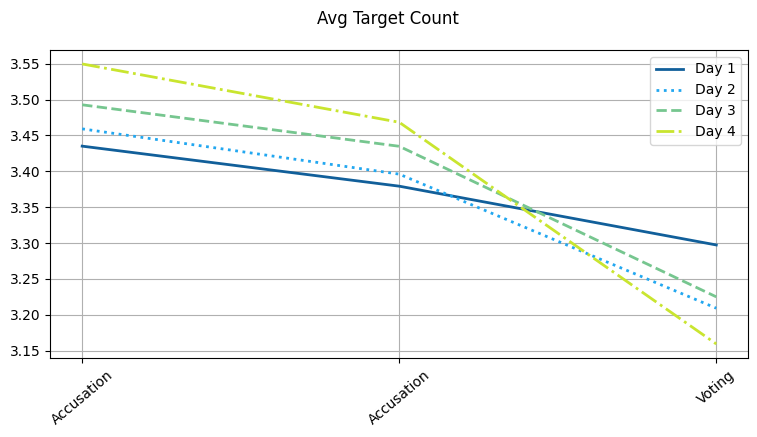

In [37]:
plot_indicator(tav_stacked[1], indicator_titles[0], 0, day_colors)

The same general behavior is exhibited regardless of the werewolves strategies. The increase on day $3$ against CRLWolves we believe can be attributed to the confusion around those werewolves usage of random likes and neutrals. 

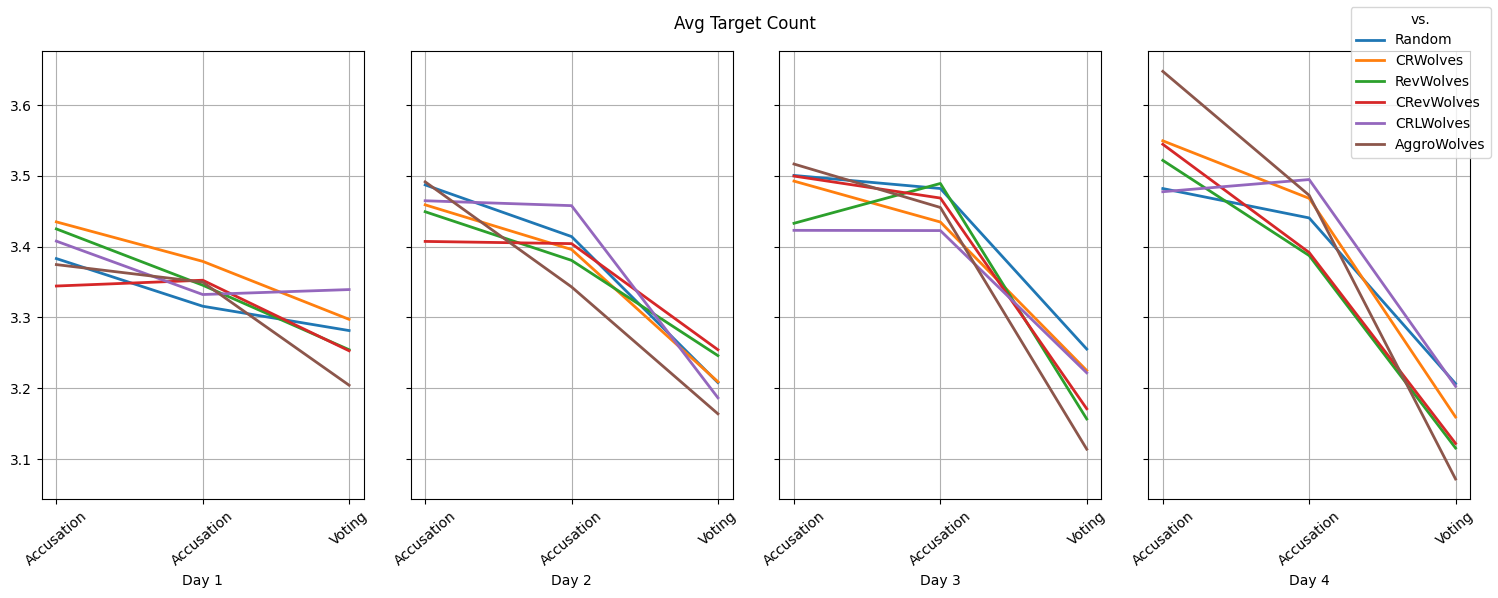

In [43]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[0], 0)

#### Average Like Count

Liking another agent does not provide agents with direct rewards, and is not mechanically relevant to elimination, so whereas humans would have used this indicator to highlight players we believe are more trustworthy, our PPO trained agents may use it in a very different way.

In contrast to targetting, agents seem to use more likes as the day progresses, possibly mirroring how a human would "like" other trusted humans.
This idea of trust is further reinforced in later indicators, where agents like who they believe are villagers, regardless of whether they are alive or dead.

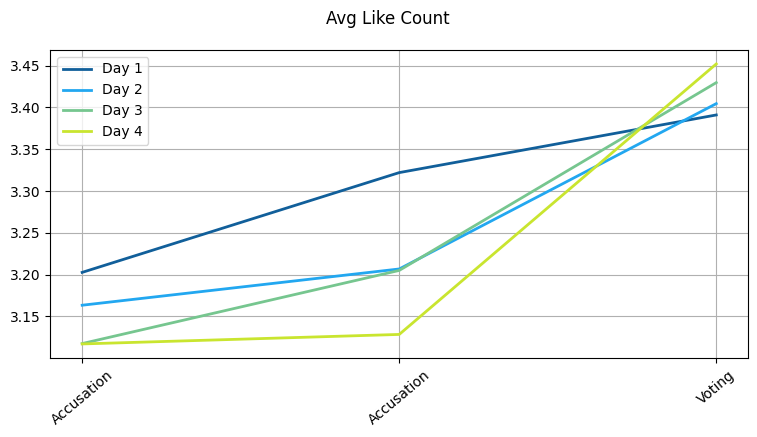

In [25]:
plot_indicator(tav_stacked[1], indicator_titles[1], 1, day_colors)

This observed increase is also seen when playing other agents, with less likes towards CRLWolves and AggroWolves. We believe this strengthens the idea of trained agents liking other trusted players.

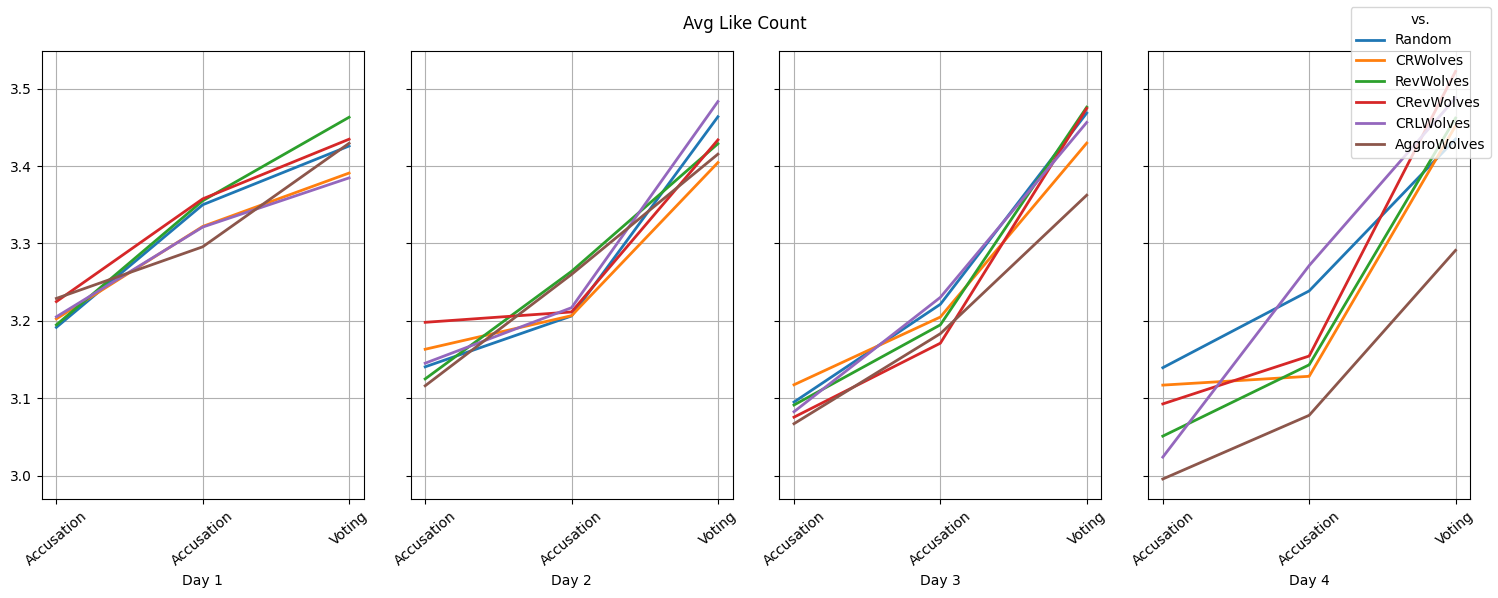

In [44]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[1], 1)

#### Average Neutral Count

The third option an agent has in approval voting is to remain neutral towards another agent. This indicator tracks the average amount of neutrals an agent will use. 

Much like "likes", a neutral vote does not provide agents with direct rewards, and is not mechanically relevant to elimination, however the usage of neutral appears to be much more chaotic. 

We believe that because targetting and liking are at the start and the end of our classification outputs, agents actually learned this ordinal representation, and maybe neutrals are a transient spot for other agents being shuffled between targets and likes, leading to chaotic looking graphs.

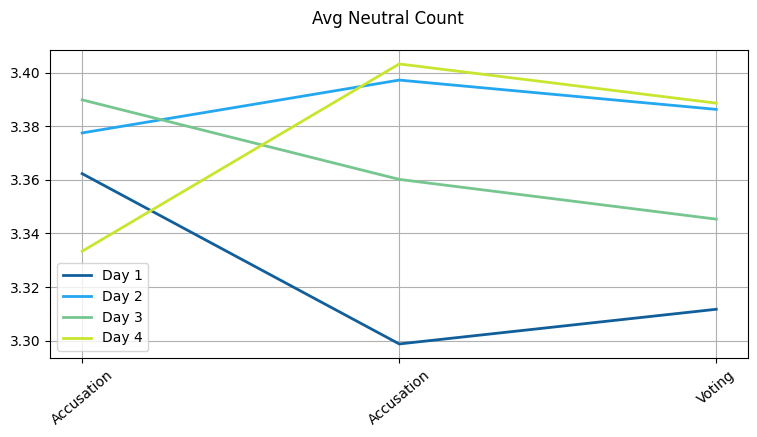

In [28]:
plot_indicator(tav_stacked[1], indicator_titles[2], 2, day_colors)

This chaotic usage is also seen in games against other policies. We had initially expectd that CRLWolves and Random wolves would have similar patterns, but even these differ quite a bit.

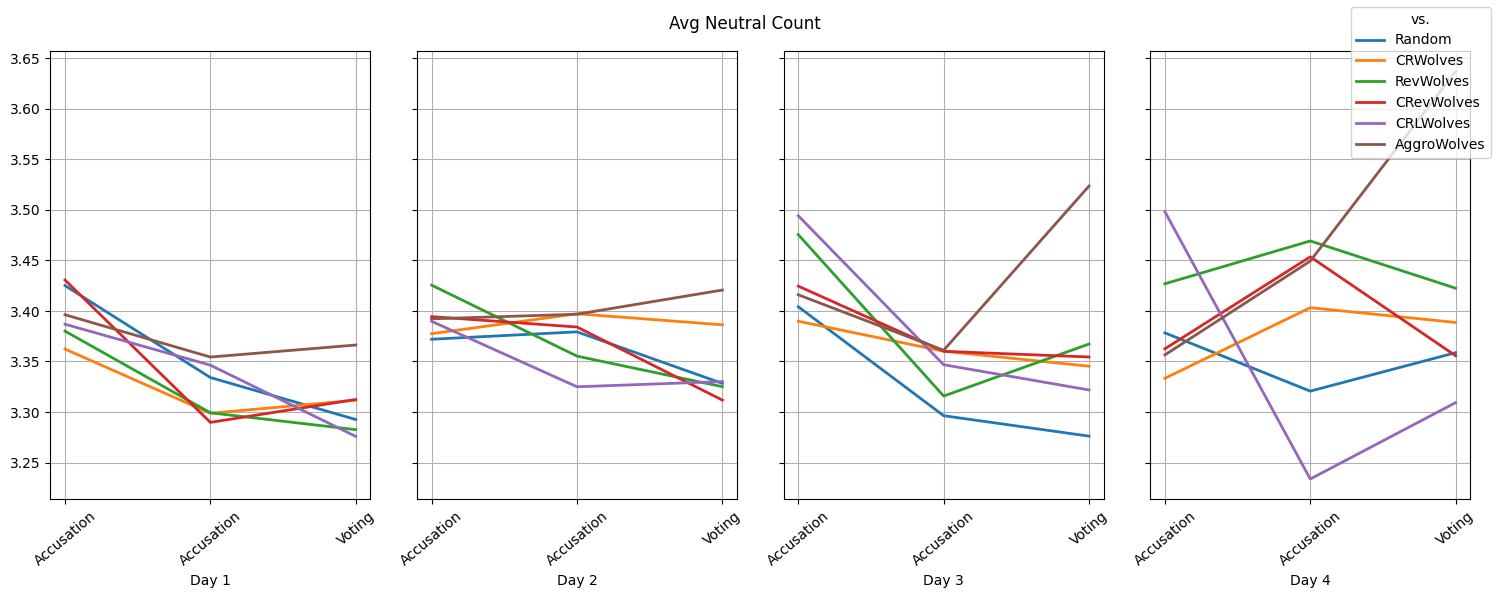

In [45]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[2], 2)

#### Likelihood of Self Targetting

This indicator tracks an agent's propensity to target themselves, and seeing a downward trend indicates two things:
1. Early targetting may be used as a type of signal
2. Less targetting during voting rounds means the agent has learned it is not a good idea to self-target during an elimination round

Targetting themselves during accusation rounds does not result in negative rewards, only if they do it during voting rounds. In addition, the surplus of targetting in approval voting leads to self-targetting not being as dangerous as in plurality.

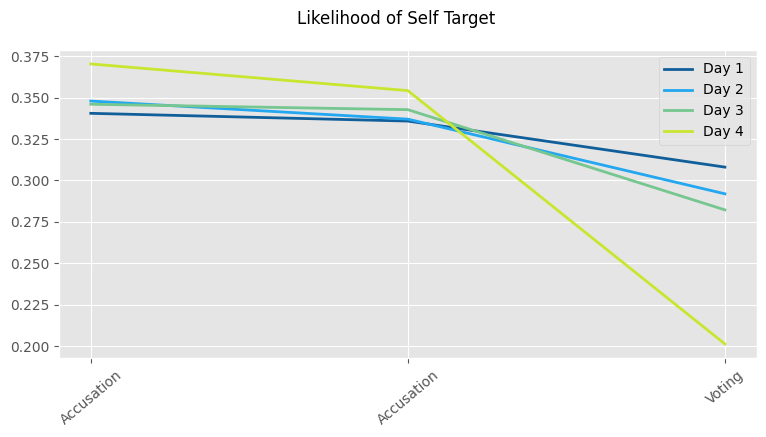

In [186]:
plot_indicator(tav_stacked[1], indicator_titles[3], 3, day_colors)

The same trend is exhibited with various werewolf policies, however AggroWolves stand out because it seems agents were able to realize it was more dangerous to self-target against these opponents.

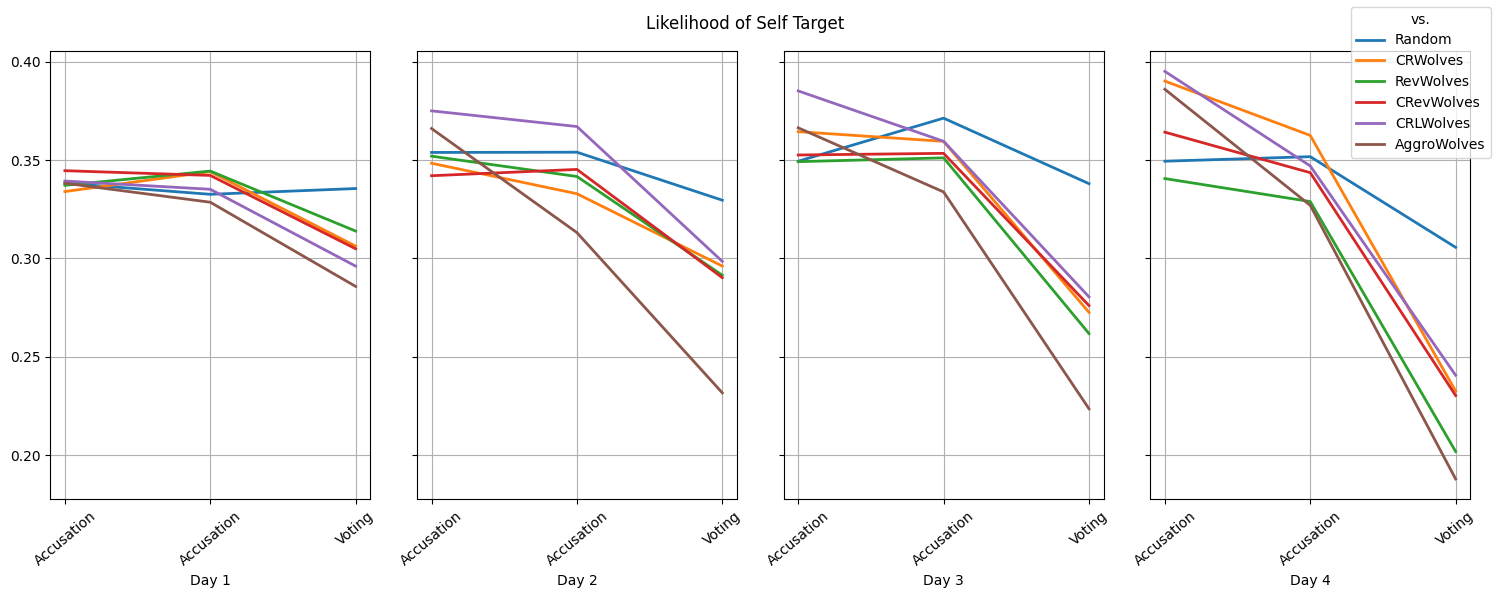

In [46]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[3], 3)

#### Likelihood of Self Liking


This indicator tracks an agent's propensity to like themselves. Interestingly, agents are less likely to use it on themselves early on in the day. There could be many different reasons for this, however two stand out:
1. CRWolves always "like" other wolves, so maybe this is a behavior they want to do sparingly to not attract suspicion.
2. It could be how sure they are of the targetting profile they have chosen

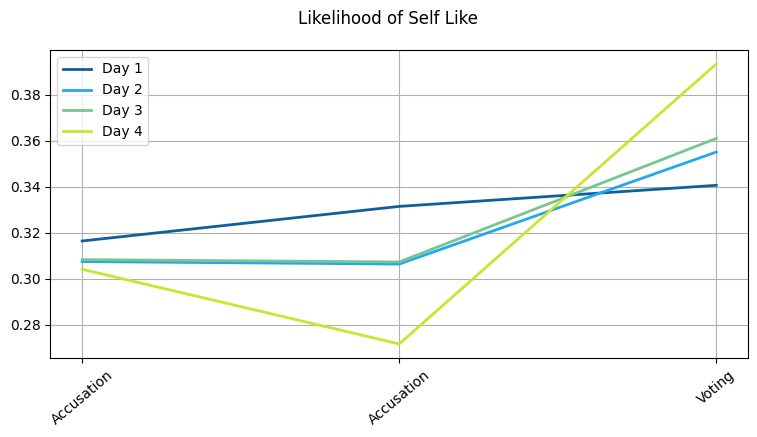

In [31]:
plot_indicator(tav_stacked[1], indicator_titles[4], 4, day_colors)

Seeing results against other werewolf policies solidifies this possibly being an assurance indicator, because against Random wolves and more prominently against CRWolves, this number dips the most before they make a more confident vote for the day

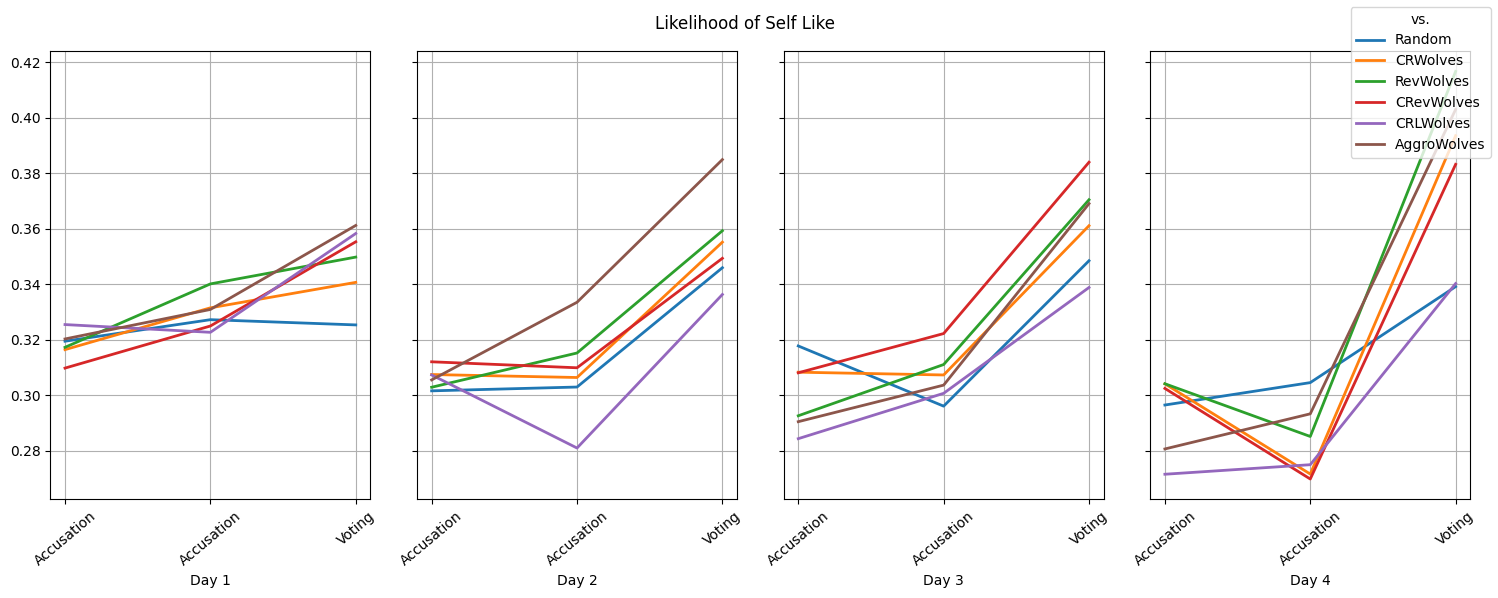

In [47]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[4], 4)

#### Percent of Wolves in Top Targets

A dynamic _Top Targets_ makes this indicator a little less compelling however it is easily interpretable. Top targets make the majority of targetting votes, and if wolves are a greater part of this, it means agents are able to better identify them.

Not only do they go up during phases in a day, each subsequent voting day has a higher share of top targets allocated to wolves.

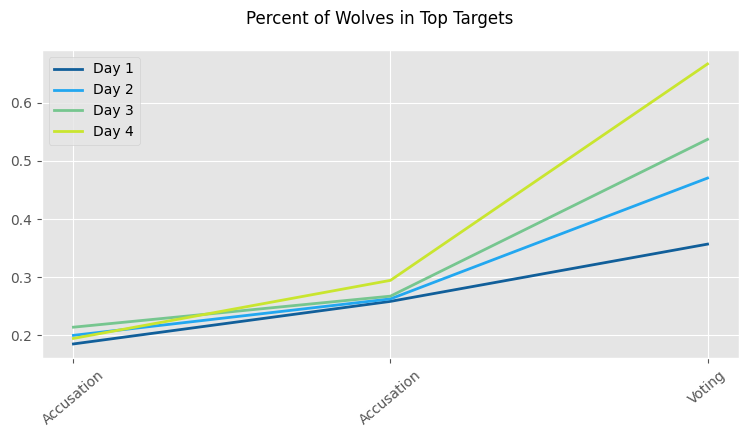

In [191]:
plot_indicator(tav_stacked[1], indicator_titles[5], 5, day_colors)

Against different policies, there is quite a stark contrast between policies with random likes/neutrals (Random, CRLWolves) and those without. Truly random werewolves are barely in the majority, whereas CRLWolves barely make it to half of top targetting by the last day. This is in contrast with AggroWolves, which are the easiest to pick out, and make up a majority of the top votes.

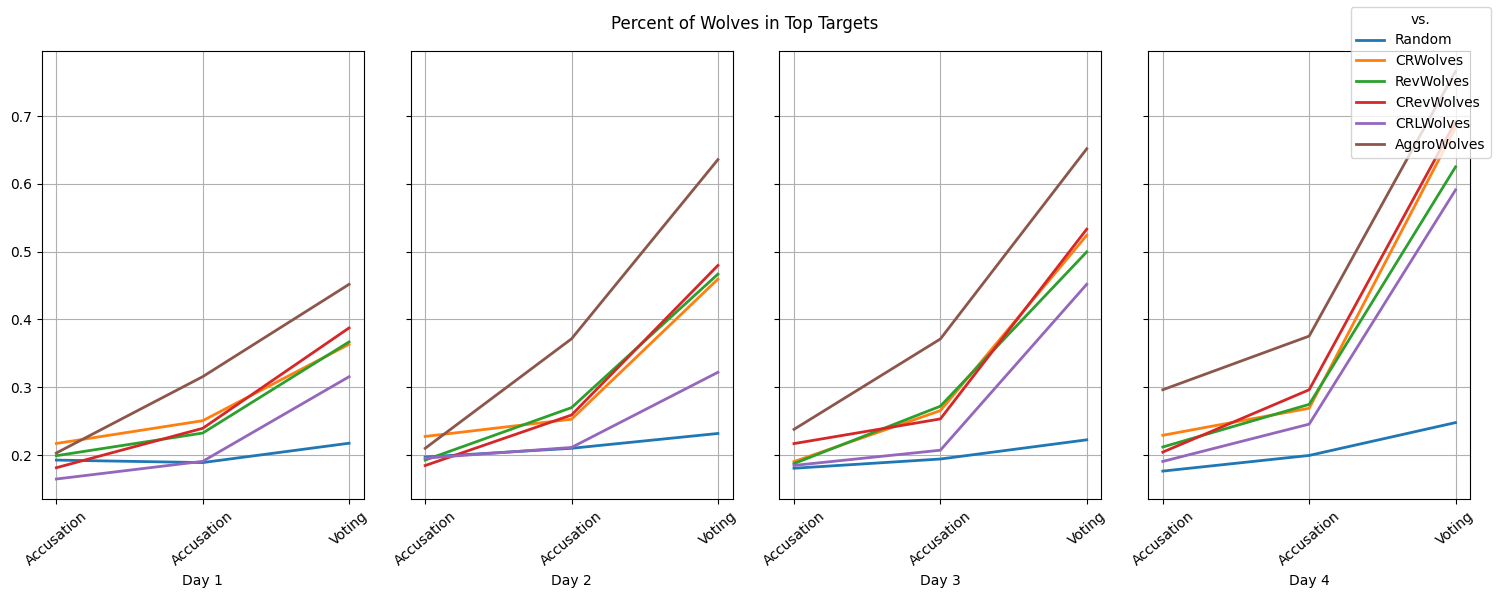

In [48]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[5], 5)

#### Percent of Wolves in Top Likes

This indicator strongly implies that trained agents will use likes to indicate trust in other agents, and as werewolves are suspected, confidence in them falls throughout the day.

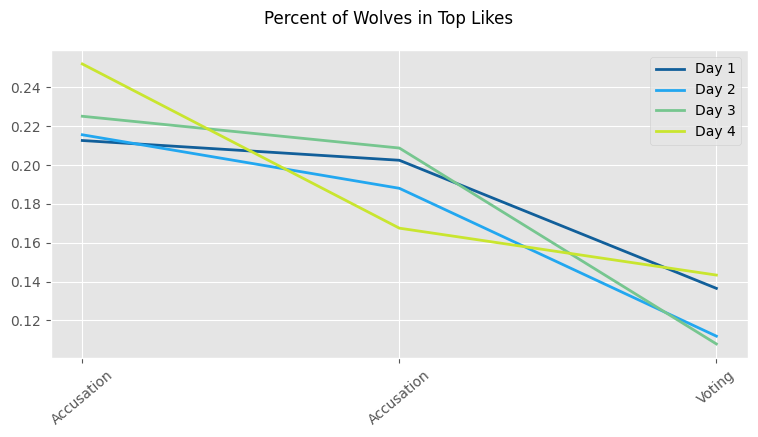

In [158]:
plot_indicator(tav_stacked[1], indicator_titles[6], 6, day_colors)

Much like how CRLWolves and Random wolves posed a problem to trained agents that could be seen in _werewolves in top targets_, we can see a parallel effect where wolves are also trusted more often against these policies, leading to more mistakes and lower win-rates. 

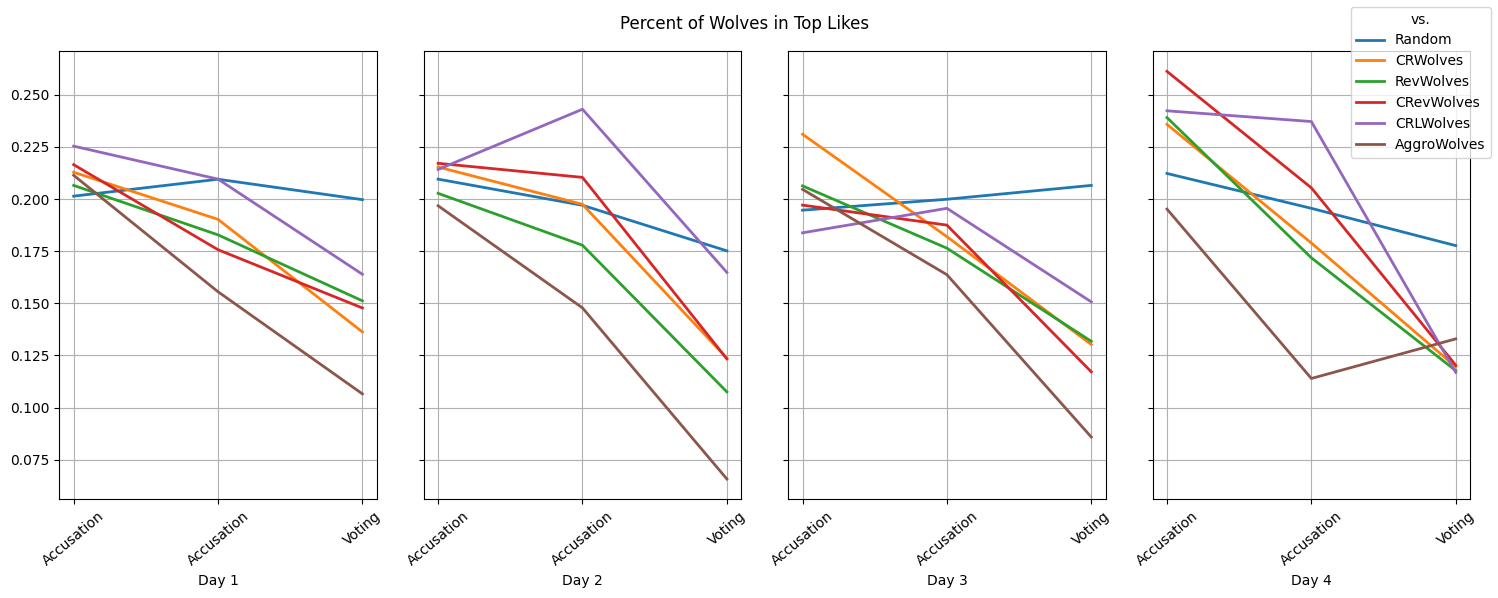

In [49]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[6], 6)

#### Percent of Votes Targetting Dead Players

Targetting dead players only results in a minor negative reward, and is masked while determining group consensus so it poses minor risk to the trained agent.

There are also more dead players every day, so seeing this number go up is not a surprise. Much like in plurality, targets towards dead players could be one of the signals villagers use amongst themselves to try to identify eachother.

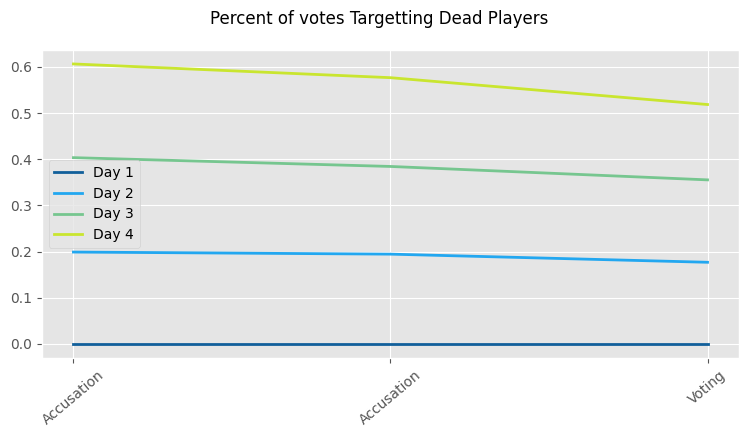

In [178]:
plot_indicator(tav_stacked[1], indicator_titles[7], 7, day_colors)

Against CRWolves and Random wolves, this number seems to be the highest, and against AggroWolves, the lowest. It could be that less signaling needs to occur when werewolves are easier to spot.

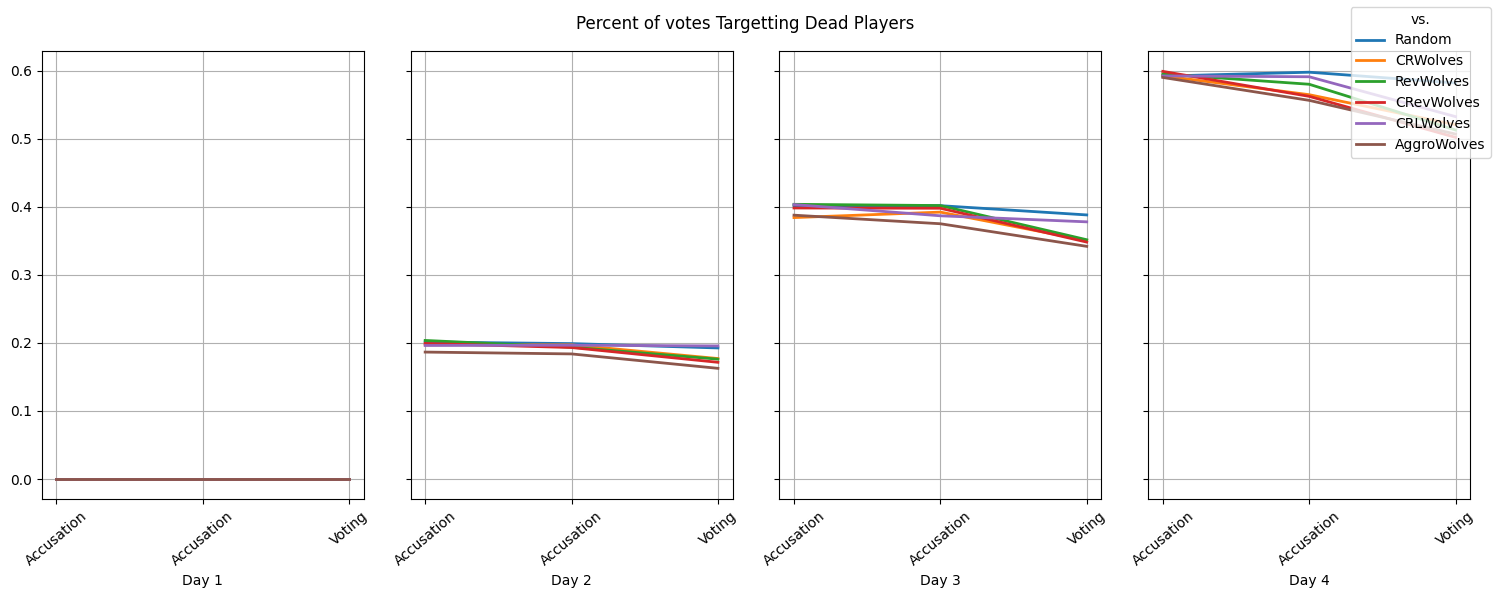

In [50]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[7], 7)

#### Percent of Votes Targetting Dead Wolves

On the heels of targets towars dead players, this indicator focuses soley on targets towards dead wolves. It is a small percentage out of the total targets towards dead players, and does not change much throughout the day other than increasing each day.

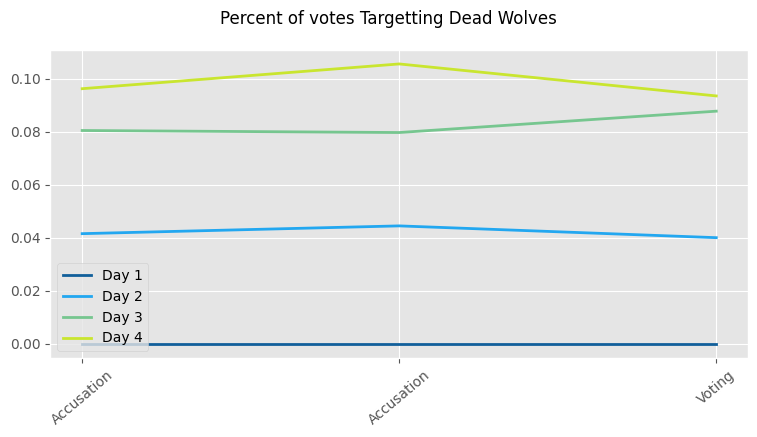

In [160]:
plot_indicator(tav_stacked[1], indicator_titles[8], 8, day_colors)

Werewolves randomly assigning likes and neutrals seem to pose problems for our trained wolves, so comparing them with the other policies is usally a good idea. In this case it would seem as though trained agents target dead CRLWolves and Random werewolves less. 

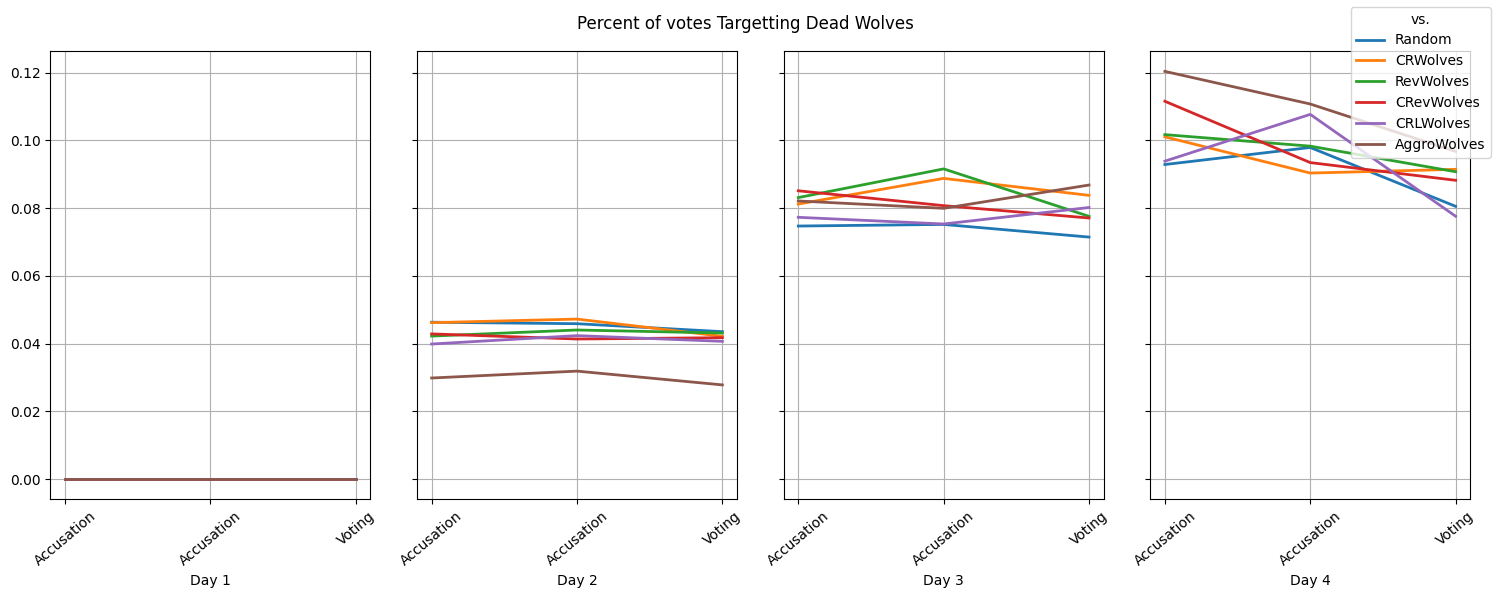

In [51]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[8], 8)

#### Percent of Votes Targetting Living Wolves

A positive trend throughout the day and culminating with the highest amount during votes indicate that werewolves are being identified and properly targetted by trained agents. Why each day's first accusatsion doesn't target them must be a strategy trained agents employ to signal to other trained agents.

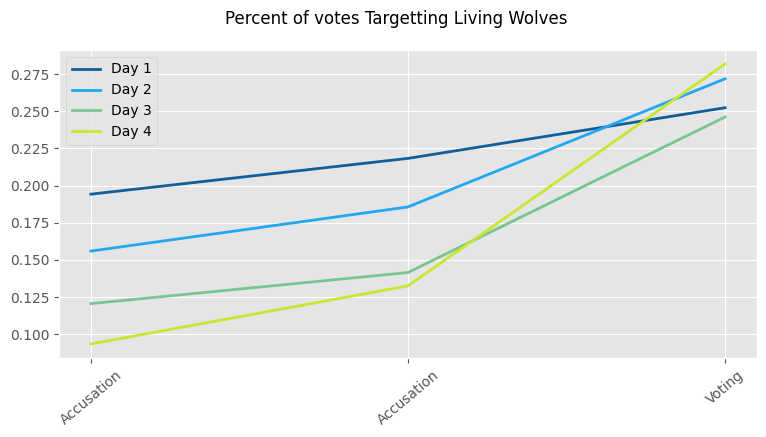

In [161]:
plot_indicator(tav_stacked[1], indicator_titles[9], 9, day_colors)

We can see that AggroWolves, which are the easiest to identify, are targetted more than any other werewolf policies, even moreso than the ones (CRWolves) the agents were trained against. In contrast, Random Wolves and CRLWolves are targetted the least, as these confuse our trained agents the most.

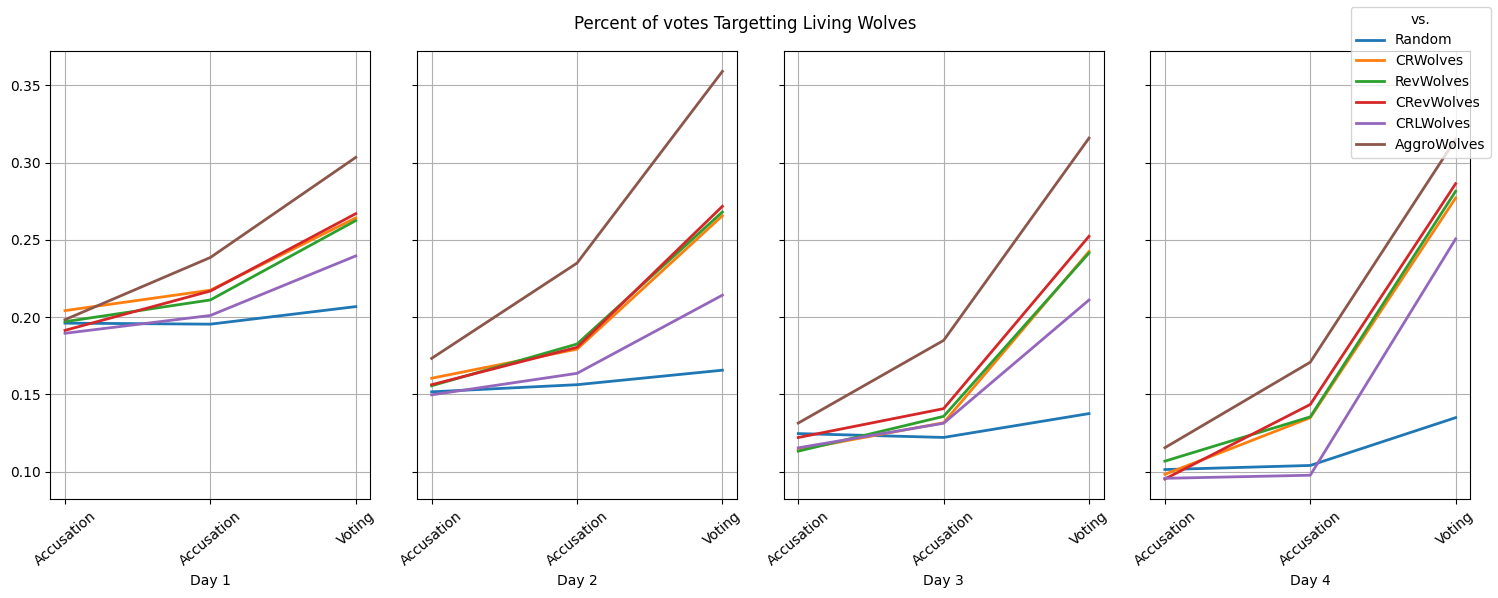

In [52]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[9], 9)

#### Percent of Likes Towards Living Villagers

This is an interesting indicator, because it shows that likes towards actual villagers do not change much throughout a day, and decreases each day. This decrease is proportional to the increase in likes for dead villagers, indicating that agents will continue to like dead players they considered true villagers, possibly to signal their knowledge to others.

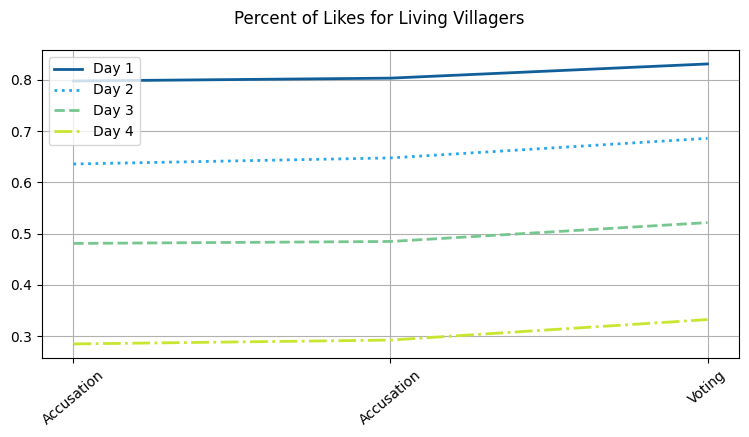

In [39]:
plot_indicator(tav_stacked[1], indicator_titles[10], 10, day_colors)

The same trend can be seen against all other werewolf policies, with no big differences for us to focus on.

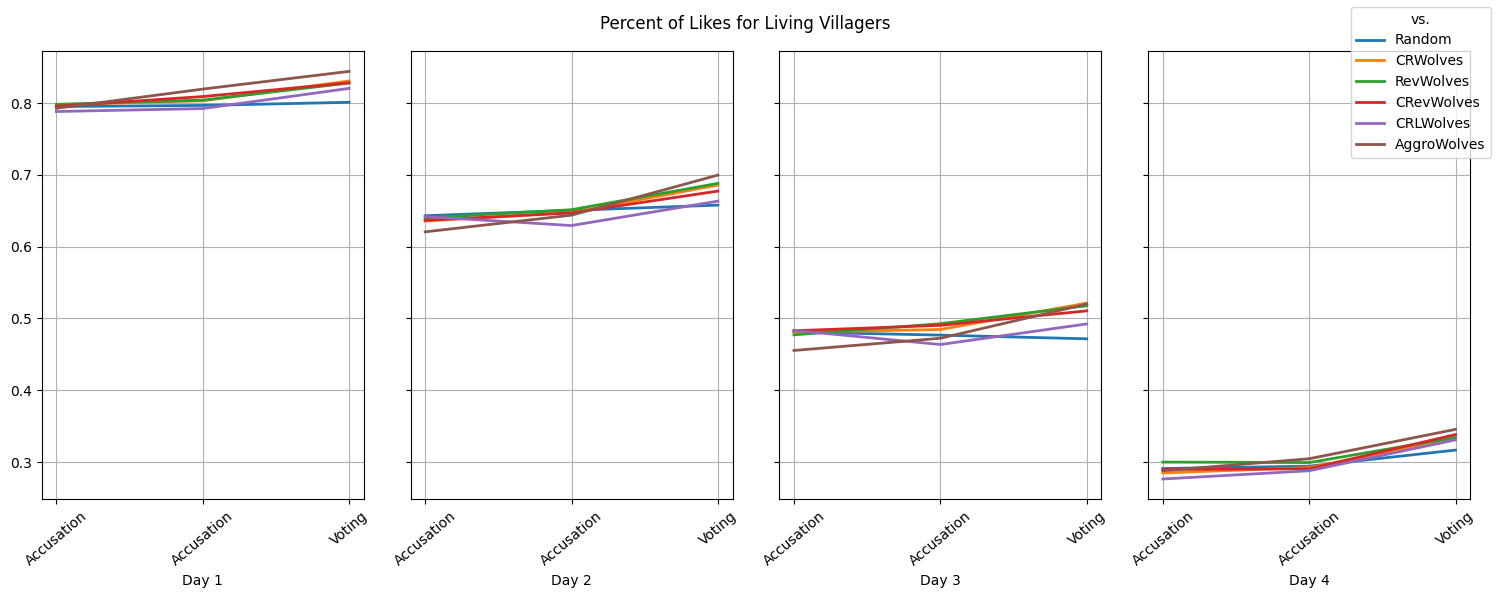

In [53]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[10], 10)

#### Percent of Likes for Dead Villagers

As villagers die, trained agents still use a "like" on them to likely signal their knowledge and beliefs in regards to the roles of other agents. It was good to have this indicator and the likes towards living villagers to be able to observe and more confidently classify this behavior.

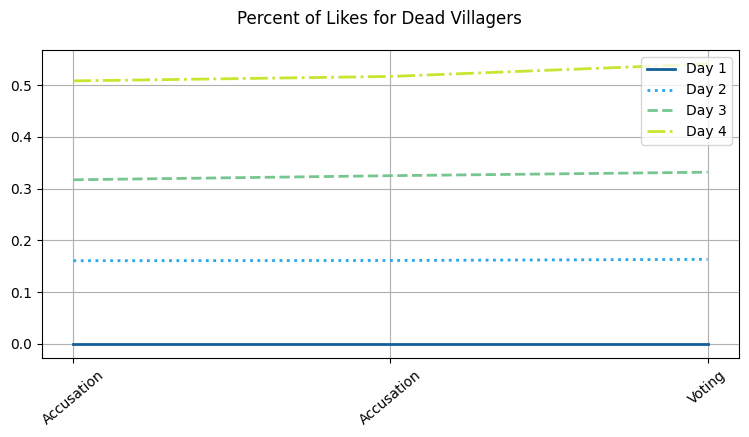

In [40]:
plot_indicator(tav_stacked[1], indicator_titles[11], 11, day_colors)

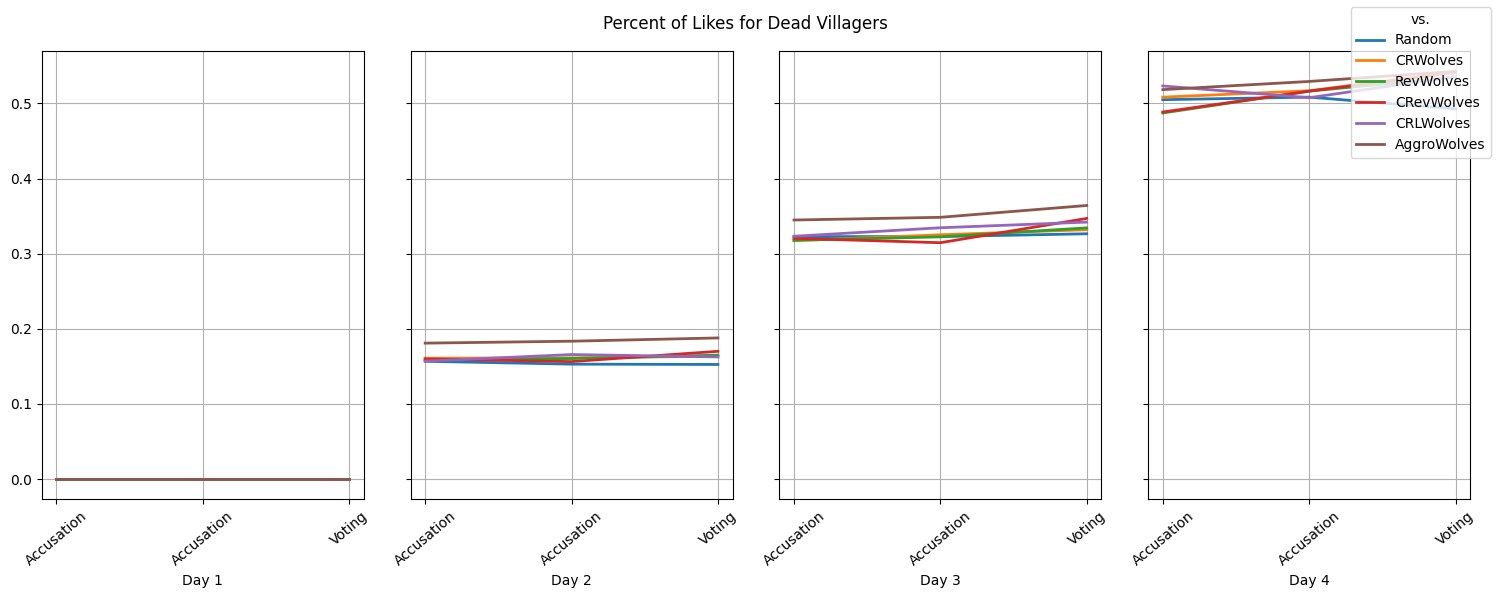

In [54]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[11], 11)

#### Percent of Likes for Dead Wolves

In contrast to likes towards villagers, likes towards wolves are low, and especially so towards dead wolves. This indicator solidifies our belief that likes have been learned to represent trust regardless of whether a player is alive or dead, and such low numbers for dead wolves indicate this.

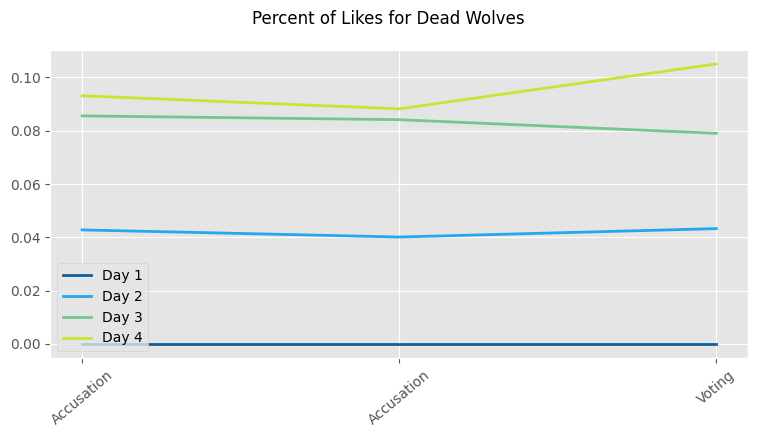

In [171]:
plot_indicator(tav_stacked[1], indicator_titles[12], 12, day_colors)

AggroWolves being the lowest so consistently across days highlight how likelier they are to be identified by trained agents.

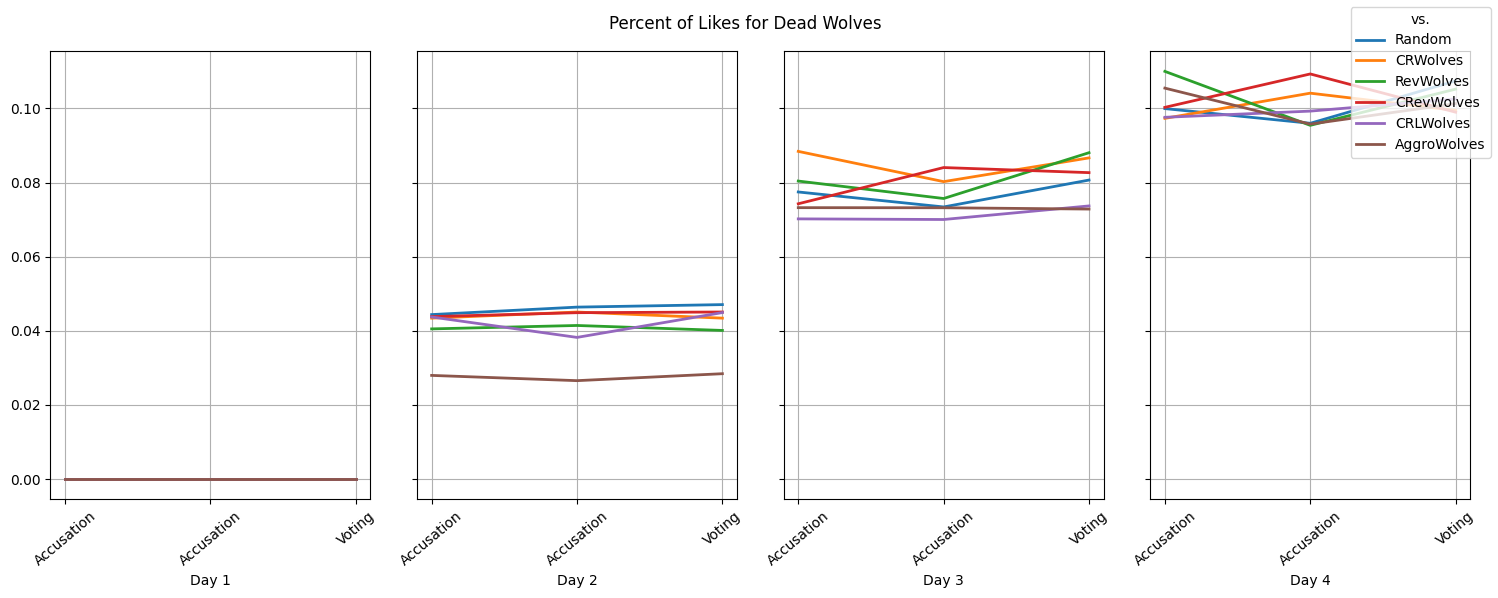

In [55]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[12], 12)

#### Percent of Likes Towards Living Wolves

This indicator shows two very critical things:
1. Wolves are not as liked as villagers, strengthening the case that likes are used for trust
2. Likes towards werewolves decrease both throughout and across days, with almost no misplaced trust in any wolves by the end of the game.

Now using this information, we can say that likes for dead wolves don't change as much because trained agents do not bother with them after they are dead.

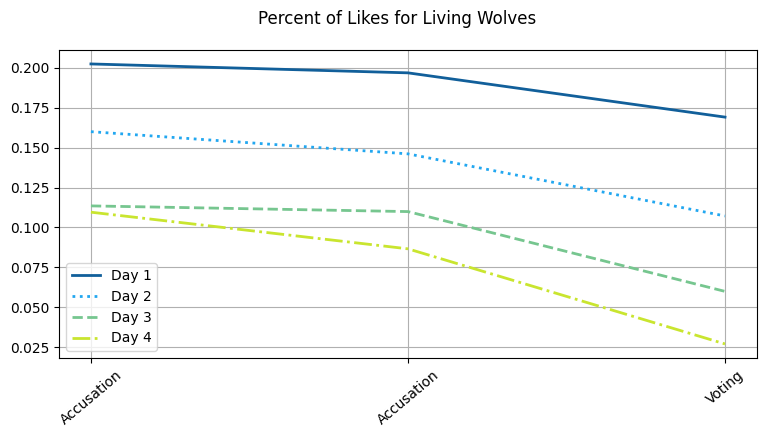

In [38]:
plot_indicator(tav_stacked[1], indicator_titles[13], 13, day_colors)

These two points come across quite clearly against different werewolf policies, with our usual tricky Random and CRLWolves having the most trust, and AggroWolves having the least.

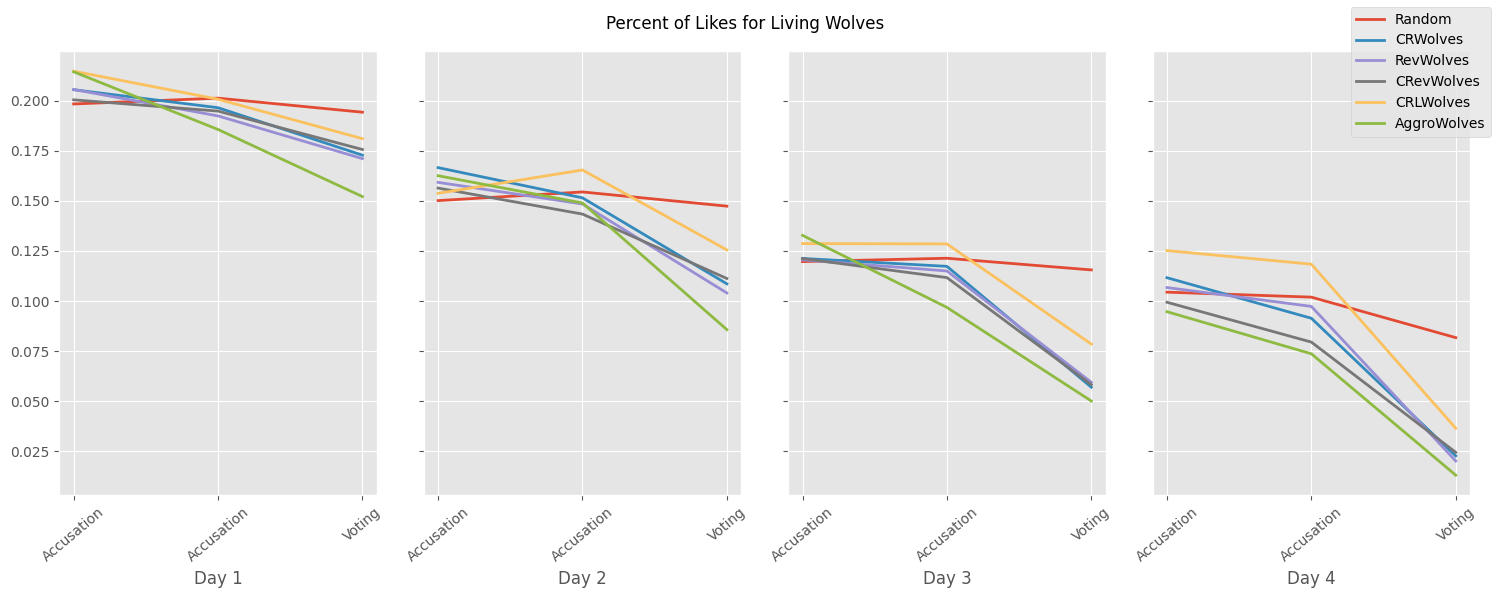

In [174]:
plot_indicator_across_other_wolves(tav_stacked, indicator_titles[13], 13)